<a href="https://colab.research.google.com/github/JionisGenius/TIL/blob/main/0920_01_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression w/ California Housing

### import

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn #class Model(nn.Module):
from torch.utils.data import Dataset, DataLoader
# Dataset: data를 컬럼 기준으로 쪼개줌 -> X, y 
# DataLoader: data를 row기준으로 Batch로 만들어줍니다. 

In [ ]:
from sklearn.datasets import fetch_california_housing

ch =  fetch_california_housing()
df = pd.DataFrame(ch.data, columns = ch.feature_names)
df['target'] = ch.target
print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df.values.shape[0]

20640

### Dataset -> DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df = df):
        self.df =df
        self.x = df.iloc[:, :-1].values # numpy
        self.y = df.iloc[:, -1:].values

    # oveeride 1) __len__: 전체 row를 반환합니다.
    def __len__(self):
        return self.x.shape[0] # len(self.df)
    
    # oveeride 2) __getitem__: row를 index 특정
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        # return x, y # numpy arrary
        return torch.tensor(x, dtype = torch.float), torch.tensor(y, dtype = torch.float)

In [ ]:
ds = MyDataset()
sample =next(iter(ds))
sample[0].shape, sample[1].shape

(torch.Size([8]), torch.Size([1]))

In [ ]:
import os
os.cpu_count()

2

In [ ]:
def prepare_loaders(df = df, index = 15640, batch_size = 512):
    # Train Valid Split
    train = df[:index].reset_index(drop = True)
    valid = df[index:].reset_index(drop = True)
    # train, valid -> MyDataset(Dataset)-> train_ds, valid_ds
    train_ds = MyDataset(df = train)
    valid_ds = MyDataset(df = valid)
    # train_ds, valid_ds ->DataLoader -> train_loader, valid_loader
    train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True, pin_memory = True)
    valid_loader = DataLoader(valid_ds, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True, pin_memory = True)
    print("DataLoader Completed")
    return train_loader, valid_loader

train_loader, valid_loader =  prepare_loaders(df = df, index = 15640, batch_size = 512)

DataLoader Completed


In [ ]:
sample =next(iter(train_loader))
sample[0].shape, sample[1].shape

(torch.Size([512, 8]), torch.Size([512, 1]))

### Model


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu") # 암기

In [ ]:
 torch.cuda.is_available()

True

In [ ]:
a = torch.tensor([1, 2, 3])
a

tensor([1, 2, 3])

In [ ]:
b = a.to(device)
b

tensor([1, 2, 3], device='cuda:0')

In [ ]:
c = a.cuda()
c

tensor([1, 2, 3], device='cuda:0')

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim = 8, output_dim = 1):
        super().__init__()
        # frame 만 정함
        # input: |bs, 8|
        # 1)
        self.fc1 = nn.Linear(8, 5)  #|(bs, 8)| -> |(bs, 5)|
        self.relu1 = nn.ReLU()      #|(bs, 5)| -> |(bs, 5)|
        self.fc2 = nn.Linear(5, 4)  #|(bs, 5)| -> |(bs, 4)|
        self.relu2 =nn.ReLU()       #|(bs, 4)| -> |(bs, 4)|
        self.last = nn.Linear(4, 1) #|(bs, 4)| -> |(bs, 1)|

        # 2)
        # self.seq = nn.Sequential(nn.Linear(8, 4), nn.ReLU(), nn.Linear(4, 1))

    # nn.Module 상속시 override 
    def forward(self, x):
        # 1)
        # x -> input -> shape |bs, 8|
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        output = self.last(x)
        # 2)
        # output = self.seq(x)
        return output



In [ ]:
model = Model(8, 1).to(device)
model

Model(
  (fc1): Linear(in_features=8, out_features=5, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=5, out_features=4, bias=True)
  (relu2): ReLU()
  (last): Linear(in_features=4, out_features=1, bias=True)
)

### Lossfunction, Optimizer

In [ ]:
loss_fn = nn.MSELoss().to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), 
                            #  lr = lr
                             )

### train_one_epoch

In [ ]:
# 1 epoch 기준
def train_one_epoch(model = model, loss_fn = loss_fn, dataloader = train_loader, 
                    optimizer = optimizer, scheduler = None, device = device):
    model.train() # model을 학습시키겠다는 의지표명
    train_loss = 0
    # dataloader= Train_loader
    for data in dataloader:
        x_i = data[0].to(device) # x_i.shape = |bs, 8|
        y_true = data[1].to(device) # y_true = |bs, 1|
        y_pred = model(x_i)
        loss = loss_fn(y_pred, y_true)

        # 딥러닝에서 가장 중요한 거
        optimizer.zero_grad() # gradient chogihwa
        loss.backward() # gradients for backpropagation
        optimizer.step() # weight update
        if scheduler is not None:
            scheduler.step() # lr 갈구기
        # epoch 당 train_loss 뱉어주기
        train_loss += float(loss) # loss.item()
    train_loss /= len(dataloader)
    return train_loss


In [ ]:
len(train_loader)

30

### valid one epoch

In [ ]:
# 1 epoch 기준
# model 성능 평가만

@torch.no_grad()    # 학습을 안 시키겠다는 필수 의지표명 2
def valid_one_epoch(model = model, loss_fn = loss_fn, dataloader = valid_loader, device = device):
    model.eval() # model을 학습 안 시키겠다는 의지표명

    valid_loss = 0
    # 학습을 안 시키겠다는 필수 의지표명 1
    with torch.no_grad():
        # dataloader= valid_loader
        for data in dataloader:
            x_i = data[0].to(device) # x_i.shape = |bs, 8|
            y_true = data[1].to(device) # y_true = |bs, 1|
            y_pred = model(x_i)
            loss = loss_fn(y_pred, y_true)

            # epoch 당 train_loss 뱉어주기
            valid_loss += float(loss) # loss.item()
    valid_loss /= len(dataloader)
    return valid_loss


### Run Train

In [ ]:
import copy

In [ ]:
def run_train(model = model, loss_fn = loss_fn, 
              train_loader =train_loader, valid_loader=valid_loader, 
              optimizer = optimizer, scheduler = None, device = device):
    
    n_epochs = 300    
    train_hs, valid_hs = [], []
    print_iter= 20
    early_stop = 20
    lowest_loss, lowest_epoch = np.inf, np.inf
    best_model = None
    result = dict()
    for epoch in range(n_epochs):

        train_loss = train_one_epoch(model = model, loss_fn = loss_fn, 
                                     dataloader = train_loader, optimizer = optimizer, 
                                     scheduler = None, device = device)
        valid_loss = valid_one_epoch(model = model, loss_fn = loss_fn, 
                                     dataloader = valid_loader, device = device)
        
        # 줍줍
        train_hs.append(train_loss)
        valid_hs += [valid_loss]

        # monitoring
        if (epoch + 1) % print_iter ==0:
            print("Epoch:%d, train_loss=%.3e, valid_loss=%.3e, lowest_loss=%.3e" % (epoch+1, train_loss, valid_loss, lowest_loss))

        # lowest loss 갱신
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            # 1) save
            best_model = copy.deepcopy(model.state_dict())
            # 2) save
            torch.save(model.state_dict(), "./model.pth") # model.bin
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("넌 삽질 중")
                break
                # 오버피팅 방지

    print("The best Validation Loss=%.3e at %d Epoch" % (lowest_loss, lowest_epoch))
    
    #model load
    # 1) load
    model.load_state_dict(best_model)
    # 2) load
    model.load_state_dict(torch.load("./model.pth"))

    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    return model, result



In [ ]:
model, result = run_train(model = model, loss_fn = loss_fn, 
                        train_loader =train_loader, valid_loader=valid_loader, 
                        optimizer = optimizer, scheduler = None, device = device)
    

Epoch:20, train_loss=1.365e+00, valid_loss=2.075e+00, lowest_loss=2.104e+00
Epoch:40, train_loss=1.300e+00, valid_loss=1.871e+00, lowest_loss=1.878e+00
Epoch:60, train_loss=1.175e+00, valid_loss=1.714e+00, lowest_loss=1.729e+00
Epoch:80, train_loss=8.757e-01, valid_loss=1.364e+00, lowest_loss=1.386e+00
Epoch:100, train_loss=6.841e-01, valid_loss=1.084e+00, lowest_loss=1.087e+00
Epoch:120, train_loss=6.162e-01, valid_loss=9.628e-01, lowest_loss=9.287e-01
Epoch:140, train_loss=5.935e-01, valid_loss=9.073e-01, lowest_loss=9.072e-01
Epoch:160, train_loss=5.863e-01, valid_loss=8.467e-01, lowest_loss=8.125e-01
Epoch:180, train_loss=5.893e-01, valid_loss=8.410e-01, lowest_loss=7.969e-01
넌 삽질 중
The best Validation Loss=7.969e-01 at 172 Epoch


### Visualization

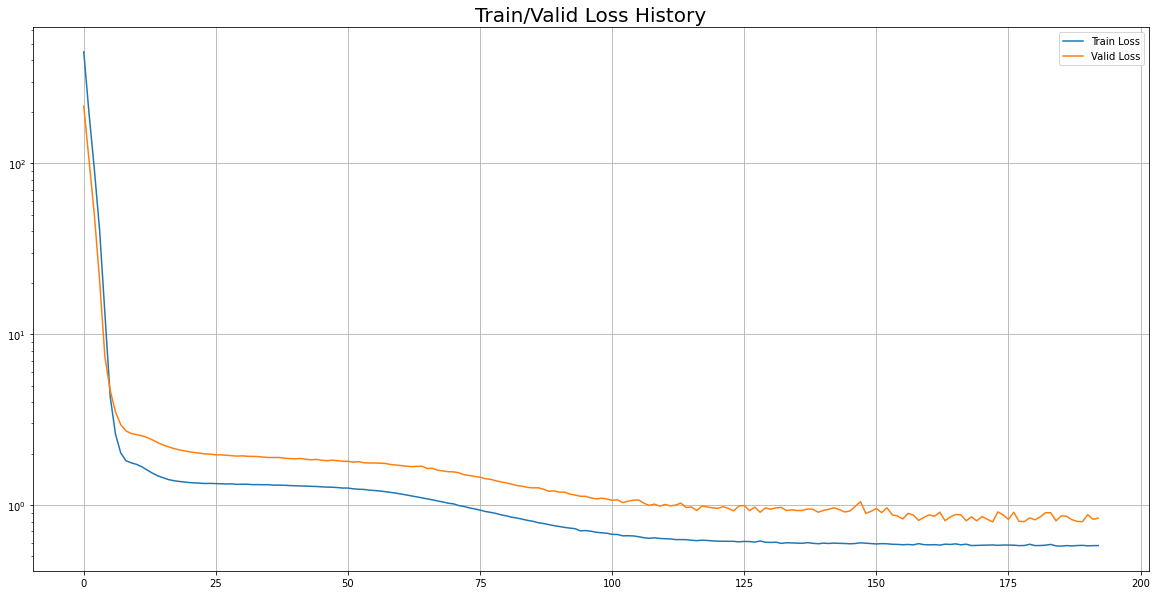

In [ ]:
## Train/Valid History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [ ]:
num = 1000
print(f"숫자: {num}")

숫자: 1000


In [ ]:
num = 1000
print("숫자: %d" % num)

숫자: 1000


In [ ]:
num = 3.12313232
print("숫자: %.3e" % num)

숫자: 3.123e+00


In [ ]:
num = 1000
print("숫자: {}".format(num))

숫자: 1000


In [ ]:
%ls

model.pth  sample_data/
